In [96]:
import numpy as np 
import pandas as pd 
import numpy as np
import cv2 
import os 
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [97]:
import pathlib
link='data\Soil types'
data_dir=pathlib.Path(link)
data_dir

WindowsPath('data/Soil types')

In [98]:
def laod_images_opencv_extisions(path):
    ext = [".jpg",".gif",".png",".tga",".webp",'.jpeg']   # Add image formats here
    files = []
    images = []
    [files.extend(data_dir.glob(path + '/*' + e)) for e in ext]
    return files

In [99]:
for i in os.walk(link):
    print(i[0])

data\Soil types
data\Soil types\Black Soil
data\Soil types\Cinder Soil
data\Soil types\Laterite Soil
data\Soil types\Peat Soil
data\Soil types\Yellow Soil


In [100]:

classes= [i.split('\\')[-1] for i in [x[0] for x in os.walk(link)][1:]]
classes

['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil']

In [101]:
len(classes)

5

In [102]:
image_dir={}
for i in classes:
    image_dir[i]=laod_images_opencv_extisions(i)
image_dir[classes[0]][:5]

[WindowsPath('data/Soil types/Black Soil/10.jpg'),
 WindowsPath('data/Soil types/Black Soil/11.jpg'),
 WindowsPath('data/Soil types/Black Soil/12.jpg'),
 WindowsPath('data/Soil types/Black Soil/13.jpg'),
 WindowsPath('data/Soil types/Black Soil/14.jpg')]

In [103]:
image_dir.keys()

dict_keys(['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil'])

In [104]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

x,y=[],[]
for imageName, imagePaths in image_dir.items():
    for img in imagePaths:
        try:
            x.append(img)
            y.append(imageName)
        except:
            continue 

dataFrame = pd.DataFrame({
    'filename': x,
    'category': y
})
dataFrame['category'] = dataFrame['category']
le=LabelEncoder()
dataFrame['category']=le.fit_transform(dataFrame['category'])
dataFrame['category'] = dataFrame['category'].astype('string')
dataFrame['filename'] = dataFrame['filename'].astype('string')
dataFrame=dataFrame.sample(frac=1)
dataFrame= dataFrame.reset_index()
dataFrame.head()  

,index,filename,category
0,79,data\Soil types\Laterite Soil\20.jpg,2
1,77,data\Soil types\Laterite Soil\19.jpg,2
2,85,data\Soil types\Laterite Soil\26.jpg,2
3,12,data\Soil types\Black Soil\21.jpg,0
4,27,data\Soil types\Black Soil\37.jpg,0


In [105]:
dataFrame.head()

,index,filename,category
0,79,data\Soil types\Laterite Soil\20.jpg,2
1,77,data\Soil types\Laterite Soil\19.jpg,2
2,85,data\Soil types\Laterite Soil\26.jpg,2
3,12,data\Soil types\Black Soil\21.jpg,0
4,27,data\Soil types\Black Soil\37.jpg,0


In [106]:
dataFrame.category.unique(

)

<StringArray>
['2', '0', '3', '4', '1']
Length: 5, dtype: string

In [107]:
from sklearn.model_selection import train_test_split
train_df, validate_df = train_test_split(dataFrame,test_size=.2,random_state=10)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [108]:
total_train,total_validate

(124, 32)

In [109]:
image_size = 224
input_shape = (image_size, image_size, 3)


batch_size = 4

In [110]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
   
    x_col='filename',
    y_col='category',

    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 124 validated image filenames belonging to 5 classes.


In [111]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
     
    x_col='filename',
    y_col='category',
    target_size=(image_size, image_size),
    batch_size=batch_size
)


Found 32 validated image filenames belonging to 5 classes.


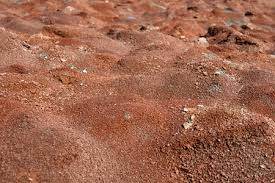

In [112]:
import PIL
PIL.Image.open(str(dataFrame['filename'][1]))

Found 1 validated image filenames belonging to 1 classes.


C:\Users\mahmo\AppData\Local\Temp\ipykernel_14356\1523263844.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


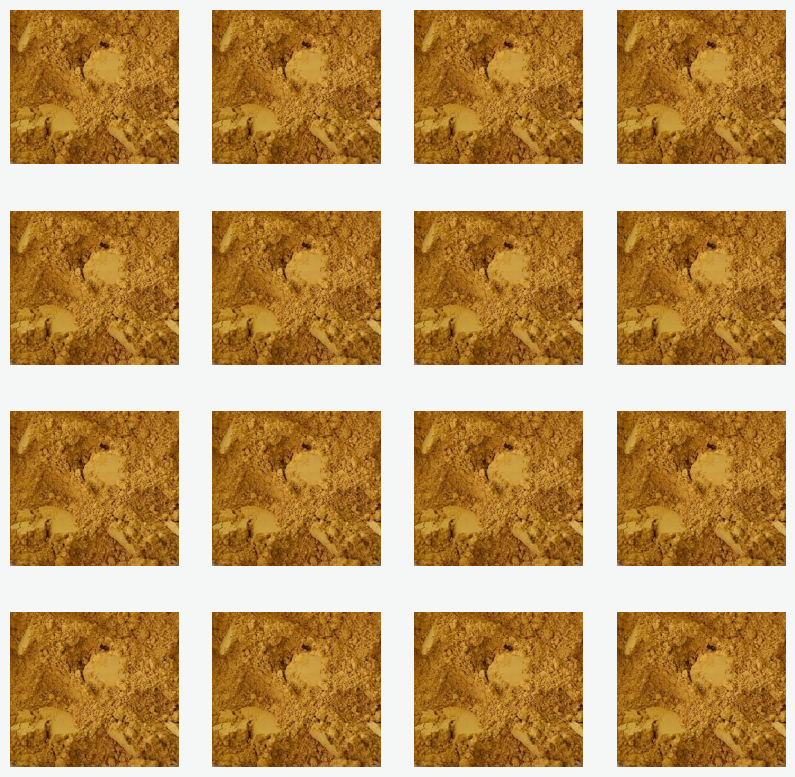

In [113]:
import matplotlib.pyplot as plt
def data_argumentation_show(n, grid_size):
    
    sample_data = train_datagen.flow_from_dataframe(
            (train_df.sample(n)),
            x_col = 'filename',
            y_col = 'category',
            target_size = (224, 244),
            class_mode = 'categorical')
  
  #subplot grid 
    fig = plt.figure(figsize = (10,10))
    fig.patch.set_facecolor('#f5f6f6')
    for i in range(0,grid_size*grid_size):
        plt.subplot(grid_size,grid_size, i+1)
        for x,y in sample_data:
            img = x[0]
            plt.imshow(img)
            plt.axis('off')
            break
            plt.tight_layout()
            del img
    fig.show()
data_argumentation_show(1,4)


# Modeling 

In [114]:
%pip install pyyaml h5py 

Note: you may need to restart the kernel to use updated packages.


In [115]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D,GlobalAveragePooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.efficientnet import EfficientNetB3

In [116]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

def myCallbacks():
    learning_rate_reduction = ReduceLROnPlateau(
        monitor='val_accuracy', 
        patience=5, 
        verbose=1, 
        factor=0.2, 
        min_lr=0.001,
        )
    es=EarlyStopping(
        monitor="val_accuracy",
        min_delta=0.01,
        patience=8,
        verbose=1,
        mode="auto",
    )
    model_cp=ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    callbacks = [es,model_cp, learning_rate_reduction]
    return callbacks

In [117]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16

input_shape = (224, 224, 3)  

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)


for layer in base_model.layers:
    layer.trainable = False

inputs = Input(shape=input_shape)
x = base_model(inputs)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(100, activation='relu')(x)
outputs = Dense(5, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               51300 

In [119]:
# def make_model():
#     base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
 
    
#     for layer in base_model.layers:
#         layer.trainable = False
    
#     add_model = Sequential()
#     add_model.add(base_model)
#     add_model.add(Dense(512,activation='relu'))
#     add_model.add(Dense(512, activation='relu'))
#     add_model.add(Dropout(0.5))
#     add_model.add(Dense(100, activation='relu'))
#     add_model.add(Dense(5, activation='softmax'))

    
#     add_model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy']) 
#     return add_model

In [120]:
# model = make_model()

In [121]:
# model.summary()

In [122]:
model.fit_generator(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=myCallbacks(),
)

Epoch 1/30


C:\Users\mahmo\AppData\Local\Temp\ipykernel_14356\2694978288.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


31/31 [==============================] - ETA: 0s - loss: 3.9076 - accuracy: 0.2339
Epoch 1: val_accuracy improved from -inf to 0.28125, saving model to training_2\cp-0001.ckpt
INFO:tensorflow:Assets written to: training_2\cp-0001.ckpt\assets


INFO:tensorflow:Assets written to: training_2\cp-0001.ckpt\assets


31/31 [==============================] - 65s 2s/step - loss: 3.9076 - accuracy: 0.2339 - val_loss: 1.6140 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 2/30
31/31 [==============================] - ETA: 0s - loss: 2.1272 - accuracy: 0.3306
Epoch 2: val_accuracy did not improve from 0.28125
31/31 [==============================] - 59s 2s/step - loss: 2.1272 - accuracy: 0.3306 - val_loss: 1.5678 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 3/30
31/31 [==============================] - ETA: 0s - loss: 1.4347 - accuracy: 0.4677
Epoch 3: val_accuracy improved from 0.28125 to 0.46875, saving model to training_2\cp-0003.ckpt
INFO:tensorflow:Assets written to: training_2\cp-0003.ckpt\assets


INFO:tensorflow:Assets written to: training_2\cp-0003.ckpt\assets


31/31 [==============================] - 64s 2s/step - loss: 1.4347 - accuracy: 0.4677 - val_loss: 1.2726 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 4/30
31/31 [==============================] - ETA: 0s - loss: 1.1374 - accuracy: 0.5403
Epoch 4: val_accuracy improved from 0.46875 to 0.65625, saving model to training_2\cp-0004.ckpt
INFO:tensorflow:Assets written to: training_2\cp-0004.ckpt\assets


INFO:tensorflow:Assets written to: training_2\cp-0004.ckpt\assets


31/31 [==============================] - 63s 2s/step - loss: 1.1374 - accuracy: 0.5403 - val_loss: 0.9922 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 5/30
31/31 [==============================] - ETA: 0s - loss: 0.8718 - accuracy: 0.6935
Epoch 5: val_accuracy did not improve from 0.65625
31/31 [==============================] - 58s 2s/step - loss: 0.8718 - accuracy: 0.6935 - val_loss: 1.0907 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 6/30
31/31 [==============================] - ETA: 0s - loss: 0.7046 - accuracy: 0.7339
Epoch 6: val_accuracy did not improve from 0.65625
31/31 [==============================] - 58s 2s/step - loss: 0.7046 - accuracy: 0.7339 - val_loss: 1.4735 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 7/30
31/31 [==============================] - ETA: 0s - loss: 0.6022 - accuracy: 0.7661
Epoch 7: val_accuracy improved from 0.65625 to 0.71875, saving model to training_2\cp-0007.ckpt
INFO:tensorflow:Assets written to: training_2\cp-0007.ckpt\assets


INFO:tensorflow:Assets written to: training_2\cp-0007.ckpt\assets


31/31 [==============================] - 62s 2s/step - loss: 0.6022 - accuracy: 0.7661 - val_loss: 0.9083 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 8/30
31/31 [==============================] - ETA: 0s - loss: 0.3305 - accuracy: 0.8710
Epoch 8: val_accuracy did not improve from 0.71875
31/31 [==============================] - 59s 2s/step - loss: 0.3305 - accuracy: 0.8710 - val_loss: 0.8552 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 9/30
31/31 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.8710
Epoch 9: val_accuracy did not improve from 0.71875
31/31 [==============================] - 61s 2s/step - loss: 0.3487 - accuracy: 0.8710 - val_loss: 1.1008 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 10/30
31/31 [==============================] - ETA: 0s - loss: 0.2498 - accuracy: 0.8952
Epoch 10: val_accuracy did not improve from 0.71875
31/31 [==============================] - 61s 2s/step - loss: 0.2498 - accuracy: 0.8952 - val_loss: 0.9638 - val_accuracy: 0.6562 - lr: 0.

INFO:tensorflow:Assets written to: training_2\cp-0012.ckpt\assets


31/31 [==============================] - 64s 2s/step - loss: 0.2283 - accuracy: 0.9194 - val_loss: 0.9030 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 13/30
31/31 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9758
Epoch 13: val_accuracy did not improve from 0.75000
31/31 [==============================] - 60s 2s/step - loss: 0.1123 - accuracy: 0.9758 - val_loss: 0.9378 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 14/30
31/31 [==============================] - ETA: 0s - loss: 0.0255 - accuracy: 1.0000
Epoch 14: val_accuracy did not improve from 0.75000
31/31 [==============================] - 60s 2s/step - loss: 0.0255 - accuracy: 1.0000 - val_loss: 1.3633 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 15/30
31/31 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.9597
Epoch 15: val_accuracy did not improve from 0.75000
31/31 [==============================] - 60s 2s/step - loss: 0.1001 - accuracy: 0.9597 - val_loss: 1.0665 - val_accuracy: 0.6562 - lr

1/1 [==============================] - 0s 155ms/step
Laterite Soil


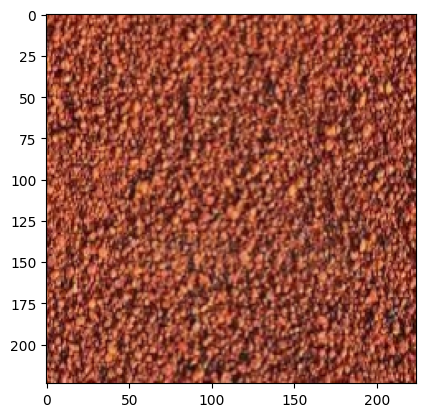

In [5]:
import cv2
import numpy as np
import matplotlib.pylab as plt
import joblib 
le=joblib.load("labels")
def pip_line(image_path):
    image=cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imageee=cv2.resize(image,(224,224))
    imageee=imageee/255.0
    plt.imshow(imageee)
    res= model.predict(np.array([imageee]))
    return le.classes_[np.argmax(res)] 
print(pip_line(r'data\Soil types\Laterite Soil\4.jpg'))

In [127]:
import joblib
joblib.dump(le,'labels')

['labels']

In [129]:
model.save('mdoel.ckpt')

INFO:tensorflow:Assets written to: mdoel.ckpt\assets


INFO:tensorflow:Assets written to: mdoel.ckpt\assets


In [2]:
model.load_weights('mdoel.ckpt')